### CHALLENGE GEOSCIENTIST/DATA SCIENTIST

In [6]:
#import the necessary modules
import rasterio as rt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd
import rasterstats as rs
import rioxarray as rtx

In [7]:
#Dispaly max rows
pd.set_option("display.max_rows", None)
#Import the dataset
ds = pd.read_csv('stenon_challenge_geoDS.csv', sep = ';', index_col=0)

## Data Cleaning
### There were few problems with the dataset:
### 1) The SOM column contained outliers
### 2) Invalid lat_lng values
### 3) NAN values
### 4) Field B residual points

In [8]:
#Visual check, discovered two outliers
#1- SOM Greater then 17
#385- Coordinates are missing
ds_mask=ds['som'] >= 7  #Came across another outlier while making comparison between Stenon SOM and Polaris SOM
filtered_ds = ds[ds_mask]
#print(filtered_ds)

In [9]:
ds = ds.drop(ds.index[[1,385, 789]])

In [10]:
#Residual points in Field B
#For refrence check Task 2: (QGIS)
rows_drop1 = ds.loc[829:902].index #Found out residual points in Field B shapefile
rows_drop2 = ds.loc[947:965].index
#print(rows_drop1)
#print(rows_drop2)
ds.drop(ds.loc[829:902].index, inplace=True)
ds.drop(ds.loc[947:965].index, inplace=True)

In [11]:
#Are there any nan values in the dataset
ds.isna().sum()
#If yes, then drop them
ds = ds.dropna() 

In [12]:
#Check dublicated values in the lat_lng column (common in Geosptial data)
ds['lat_lng'].duplicated().sum()

0

## Prepare Data for Task 3
### - Divide dataset into 2 parts: Field A and Field B
### - Field A for training models (Cols: SOM & Spectral Signatures)
### - Field B for Inference (Cols: Spectral Signatures)

In [15]:
#This cell prepares the dataset for Task 3 (Training and Inference)
#The dataset is divided into two parts, Field A and Field B
#Field A, SOM and Spectral signatures columns
#For Field B only Spectral Signatures columns
Task3_csv = ds.copy()
Split_AB = Task3_csv.groupby(Task3_csv.location)
FieldA_3 = Split_AB.get_group("field_A")
FieldA_3.drop(columns = ['lat_lng','location'], inplace = True, axis=1)
FieldB_3 = Split_AB.get_group("field_B")
FieldB_3.drop(columns = ['som', 'lat_lng','location'], inplace = True, axis=1)

#Save the Processed CSVs for Task 3
FieldA_3.to_csv('Task3_CSVs/FieldA_Pro.csv', header = True, index= False)
FieldB_3.to_csv('Task3_CSVs/FieldB_Pro.csv', header = True, index= False)

In [16]:
#Plot some of the spectral signatures
inference = pd.read_csv('Task3_CSVs/FieldB_Pro.csv')
array =  pd.DataFrame.to_numpy(inference)

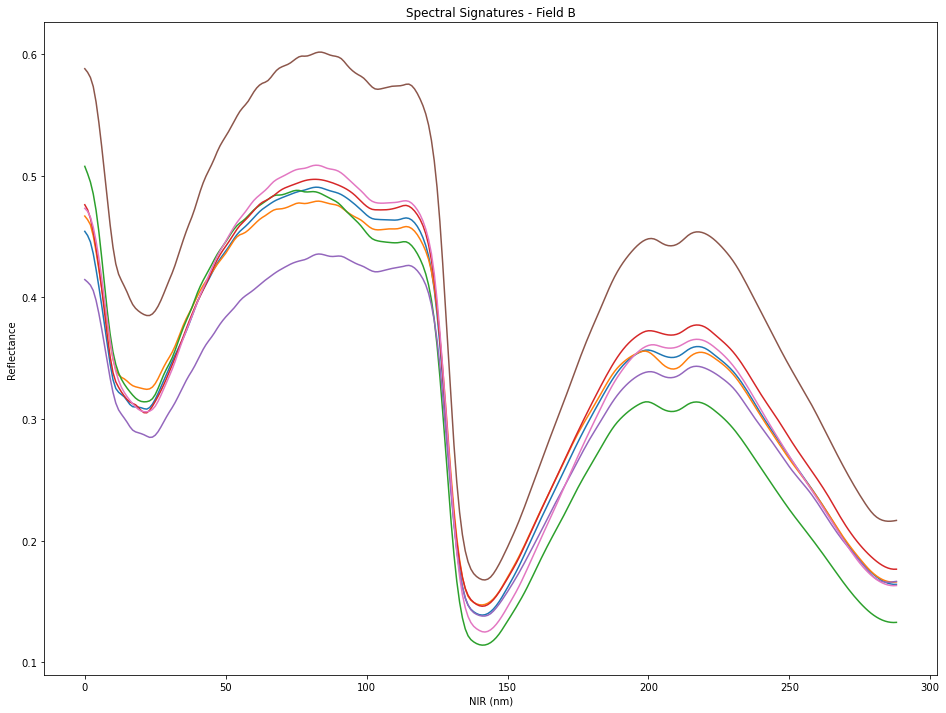

In [17]:
plt.figure(figsize=(16,12))
plt.title('Spectral Signatures - Field B')
plt.ylabel("Reflectance")
plt.xlabel('NIR (nm)')
plt.plot(array[0,:], '-')
plt.plot(array[20,:], '-')
plt.plot(array[40,:], '-')
plt.plot(array[60,:], '-')
plt.plot(array[100,:], '-')
plt.plot(array[150,:], '-')
plt.plot(array[200,:], '-')

## Preparing Data for Task 2

### 1) Split lat and lng column into two seperate columns
### 2) Select the necessary columns for Task 2
### 3) Split the dataset into field A and field B
### 3) Save the processed csv's

In [18]:
#Could not convert the lat_lng column into numeric
#Remove the brackets
ds["lat_lng"] = ds["lat_lng"].str.strip("(')")
#Split the lat_lng columns into two seperated columns
ds[['lat','lng']] = ds["lat_lng"].str.split(",",expand=True,)
#Remove the original lat_lng column
data = ds.drop(columns = ['lat_lng'], axis=1)

In [19]:
#To make a comparison between the Polaris OM and Stenon OM
#Only selected columns were extracted
#lat, long, som
data = data.loc[:, ["lat","lng","som","location"]]
#Divide the dataframe into two fields, FieldA and FieldB
Split_Fields = data.groupby(data.location)
FieldA = Split_Fields.get_group("field_A")
FieldA = FieldA.drop(columns = ['location'], axis=1)
FieldB = Split_Fields.get_group("field_B")
FieldB = FieldB.drop(columns = ['location'], axis=1)

In [20]:
#Save the dataset as a csv
FieldA.to_csv('Task2_CSVs/FieldA.csv', header = True, index= False)
FieldB.to_csv('Task2_CSVs/FieldB.csv', header = True, index= False)

### Task 2
###  Compare the estimates of the two fields from the csv file with the corresponding POLARIS estimates
### - Generate Shapefiles for Field A and Field B
### - Convert the coordinate system into Projected Coordinate System
### - Extract SOM values at points of interests
### - Compare Stenon SOM with Polaris SOM

In [21]:
#Read the Preprocessed CSVs
Field_A = pd.read_csv('Task2_CSVs/FieldA.csv')
Field_B = pd.read_csv('Task2_CSVs/FieldB.csv')

In [22]:
#Convert dataframe into a shapefile
def generate_shapefile(dataset, Path):
    shape = gpd.GeoDataFrame(dataset,
                       crs=('epsg:4326'), # Geographic Coordinates 
                       geometry=gpd.points_from_xy(dataset.lng.astype('float32'), 
                                                   dataset.lat.astype('float32')))
    #Save the genereated Geodataframe as a shapefile
    return shape.to_file(Path)

In [23]:
#Generate Shapefiles and save them
generate_shapefile(Field_A, 'Shapefiles_GCS/FieldA')
generate_shapefile(Field_B, 'Shapefiles_GCS/FieldB')

In [24]:
#Convert shapefiles refrence system to Projected Coordinate System
#def coordinates_to_UTM(Shapefile, Path):
#    UTM = Shapefile.to_crs('espg:32615')
#    return UTM.to_file(Path)

In [25]:
#Read the shapefiles
FieldA_shp = gpd.read_file("Shapefiles_GCS/FieldA/FieldA.shp")
FieldB_shp = gpd.read_file("Shapefiles_GCS/FieldB/FieldB.shp")

In [26]:
# This step is not necessary for the current task. Projected coordinates system converts a globe into a flat surface, 
# mainly performed when measuring lengths or areas or doing statistical computations on a raster data. 
# Since SOM values will be retrieved from a raster (Polaris SOM raster has also been converted), might
# possibly increase the location precision.

In [27]:
#Convert the Coordinate refrence system to Projected Coordinate System (UTM-Zone15)
FieldA_UTM = FieldA_shp.to_crs('epsg:32615') # UTM Zone 15N
FieldA_UTM.to_file("Shapefiles_UTM/FieldA_UTM")
FieldB_UTM = FieldB_shp.to_crs('epsg:32615') # UTM Zone 15N
FieldB_UTM.to_file("Shapefiles_UTM/FieldB_UTM")

### When the shapefiles were plotted, several points from Field B were included in Field A.
### Opened the shapefiles in QGIS for further examination. 
#### More data cleaning likely required

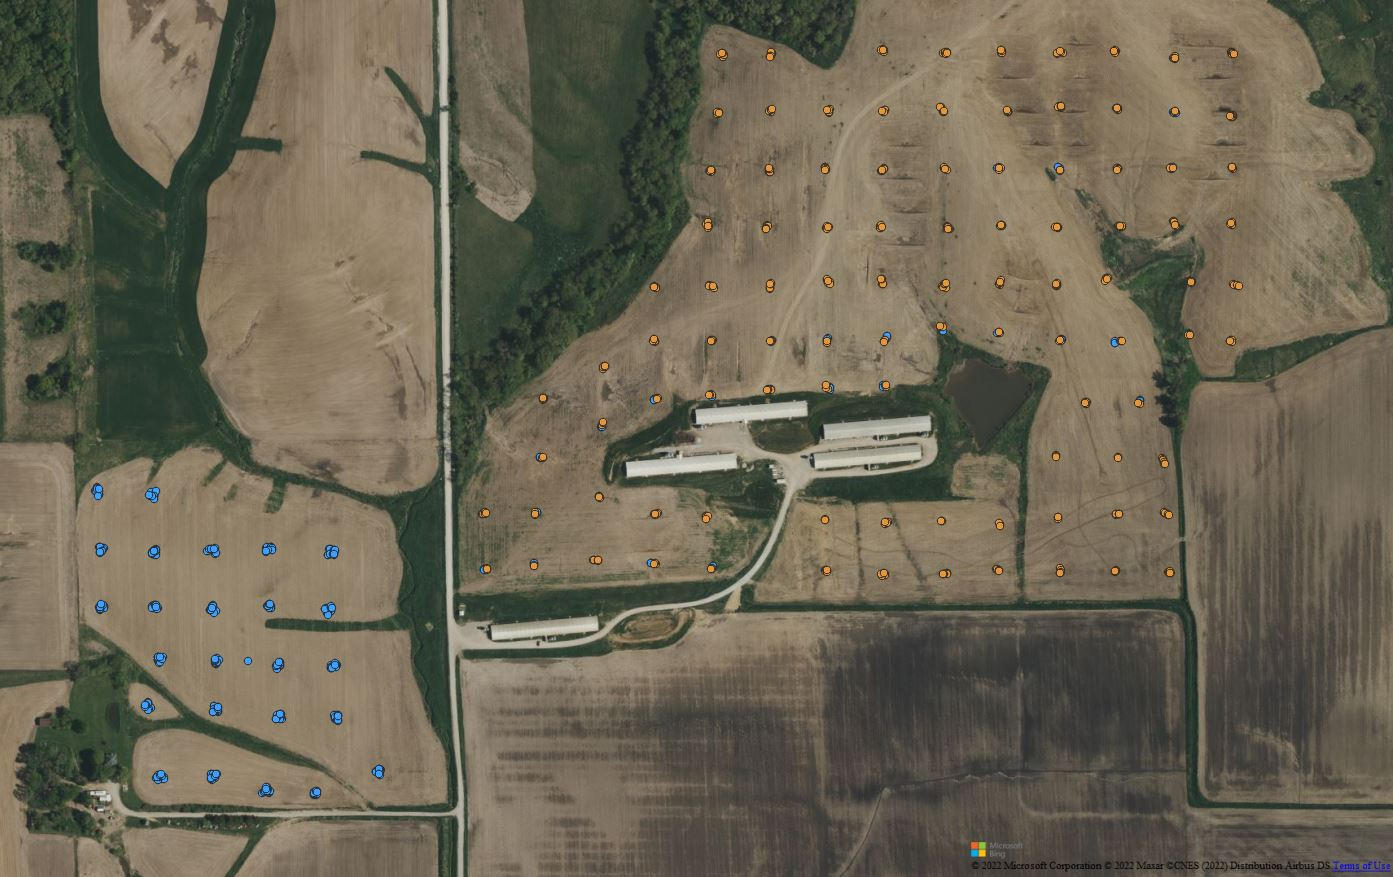

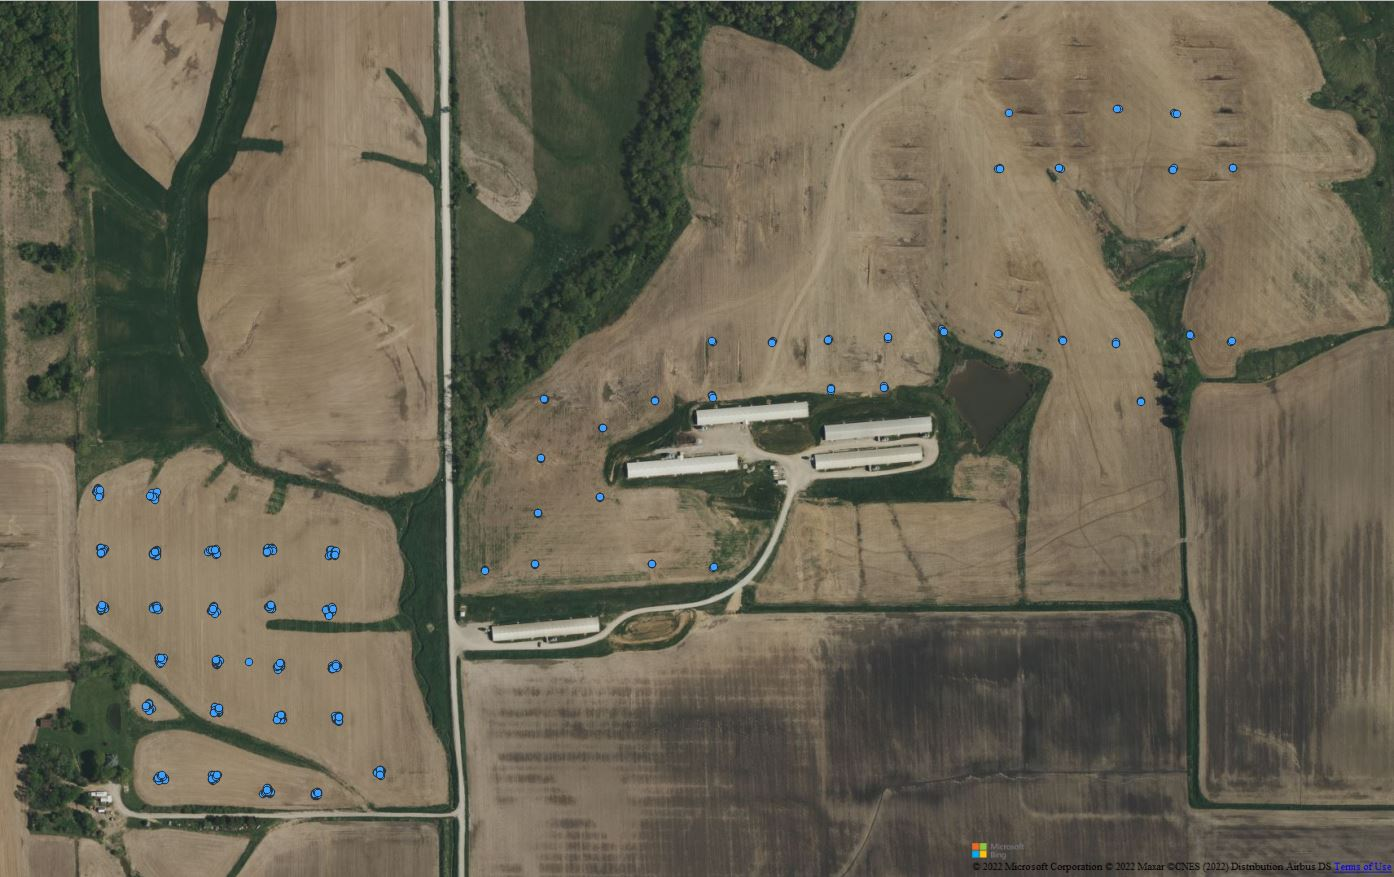

### The measurement id column in the attribute table supplied the ranges for all of the residual points in Field B.
### These ranges were utilized to remove unnecessary rows

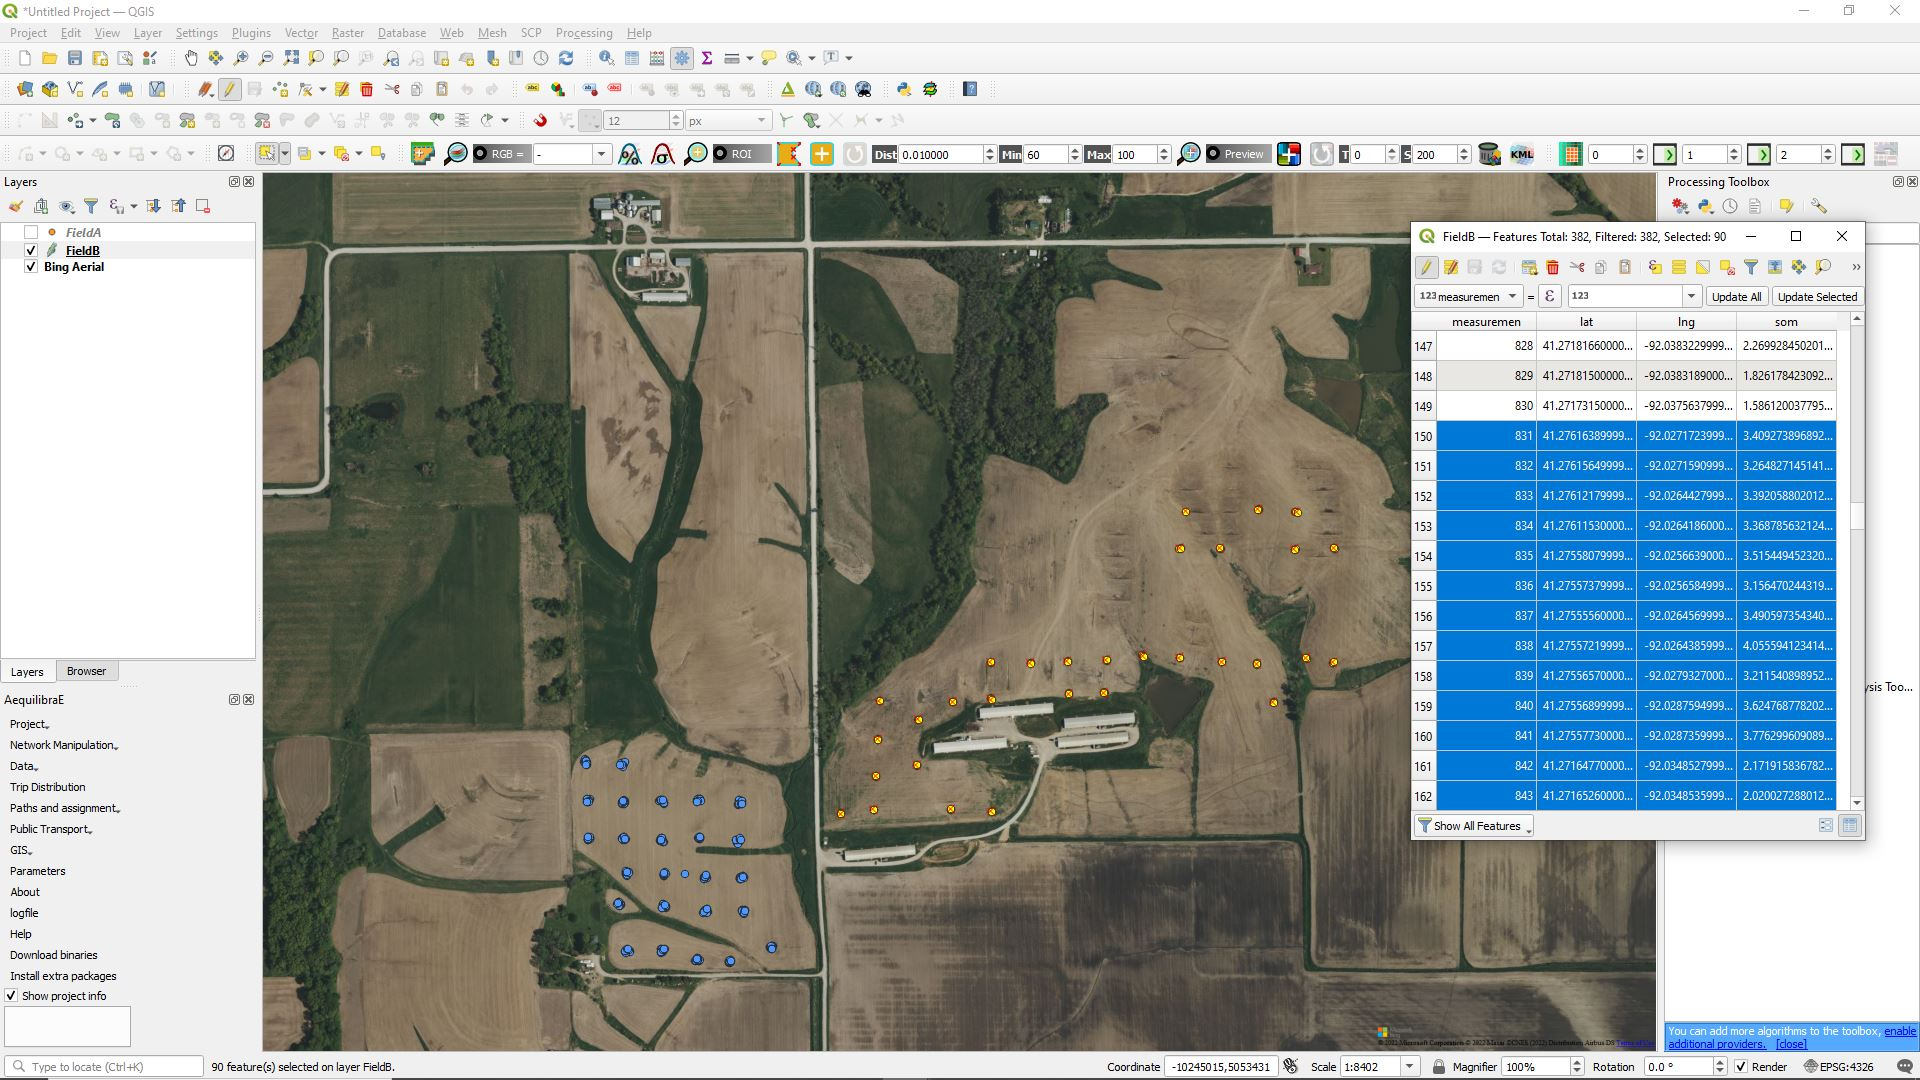

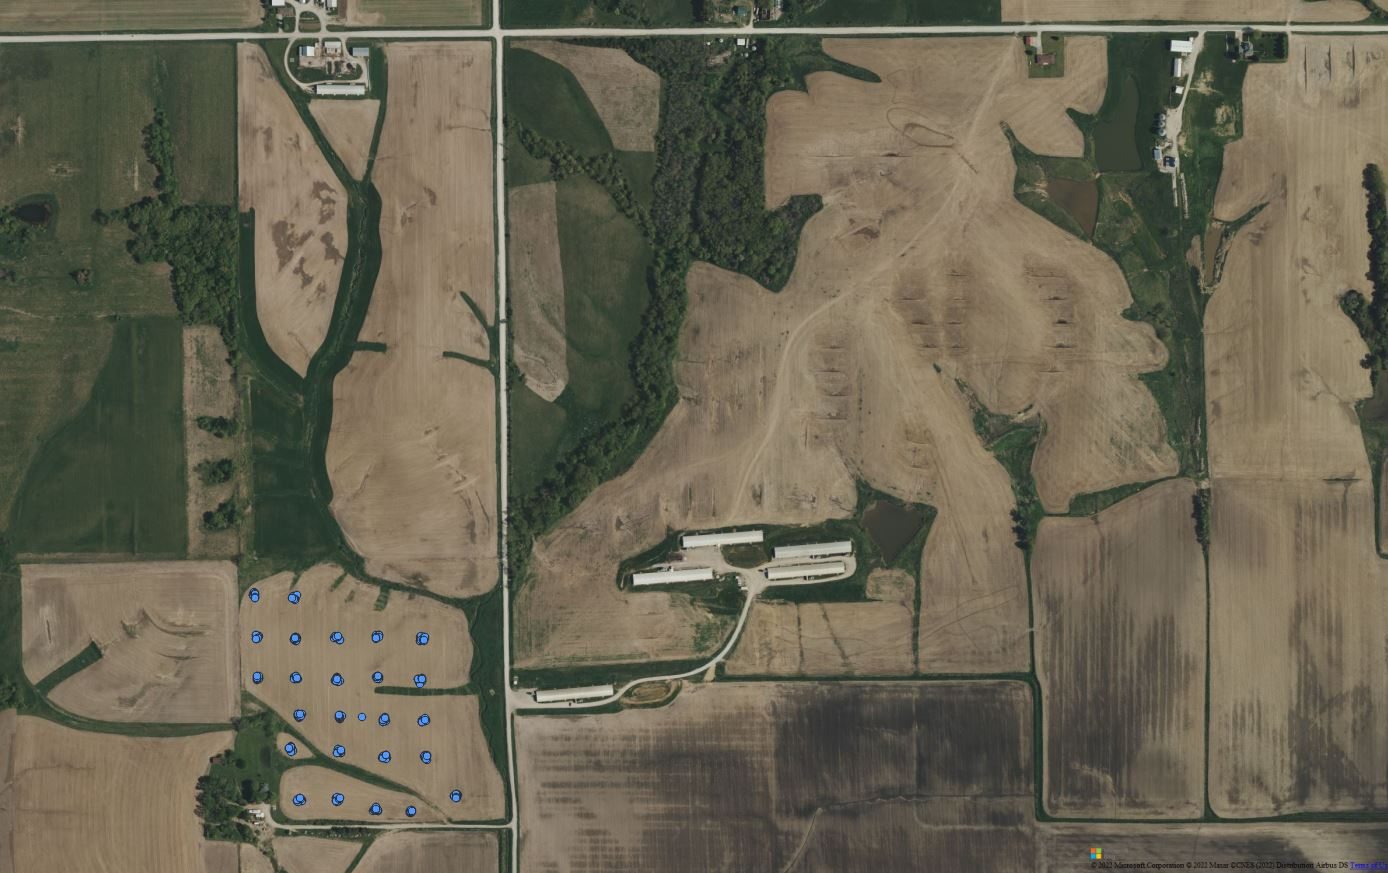

### Clipping Polaris OM raster to the study area
### Also converted to Projected Coordinate System (UTM Zone 15N)

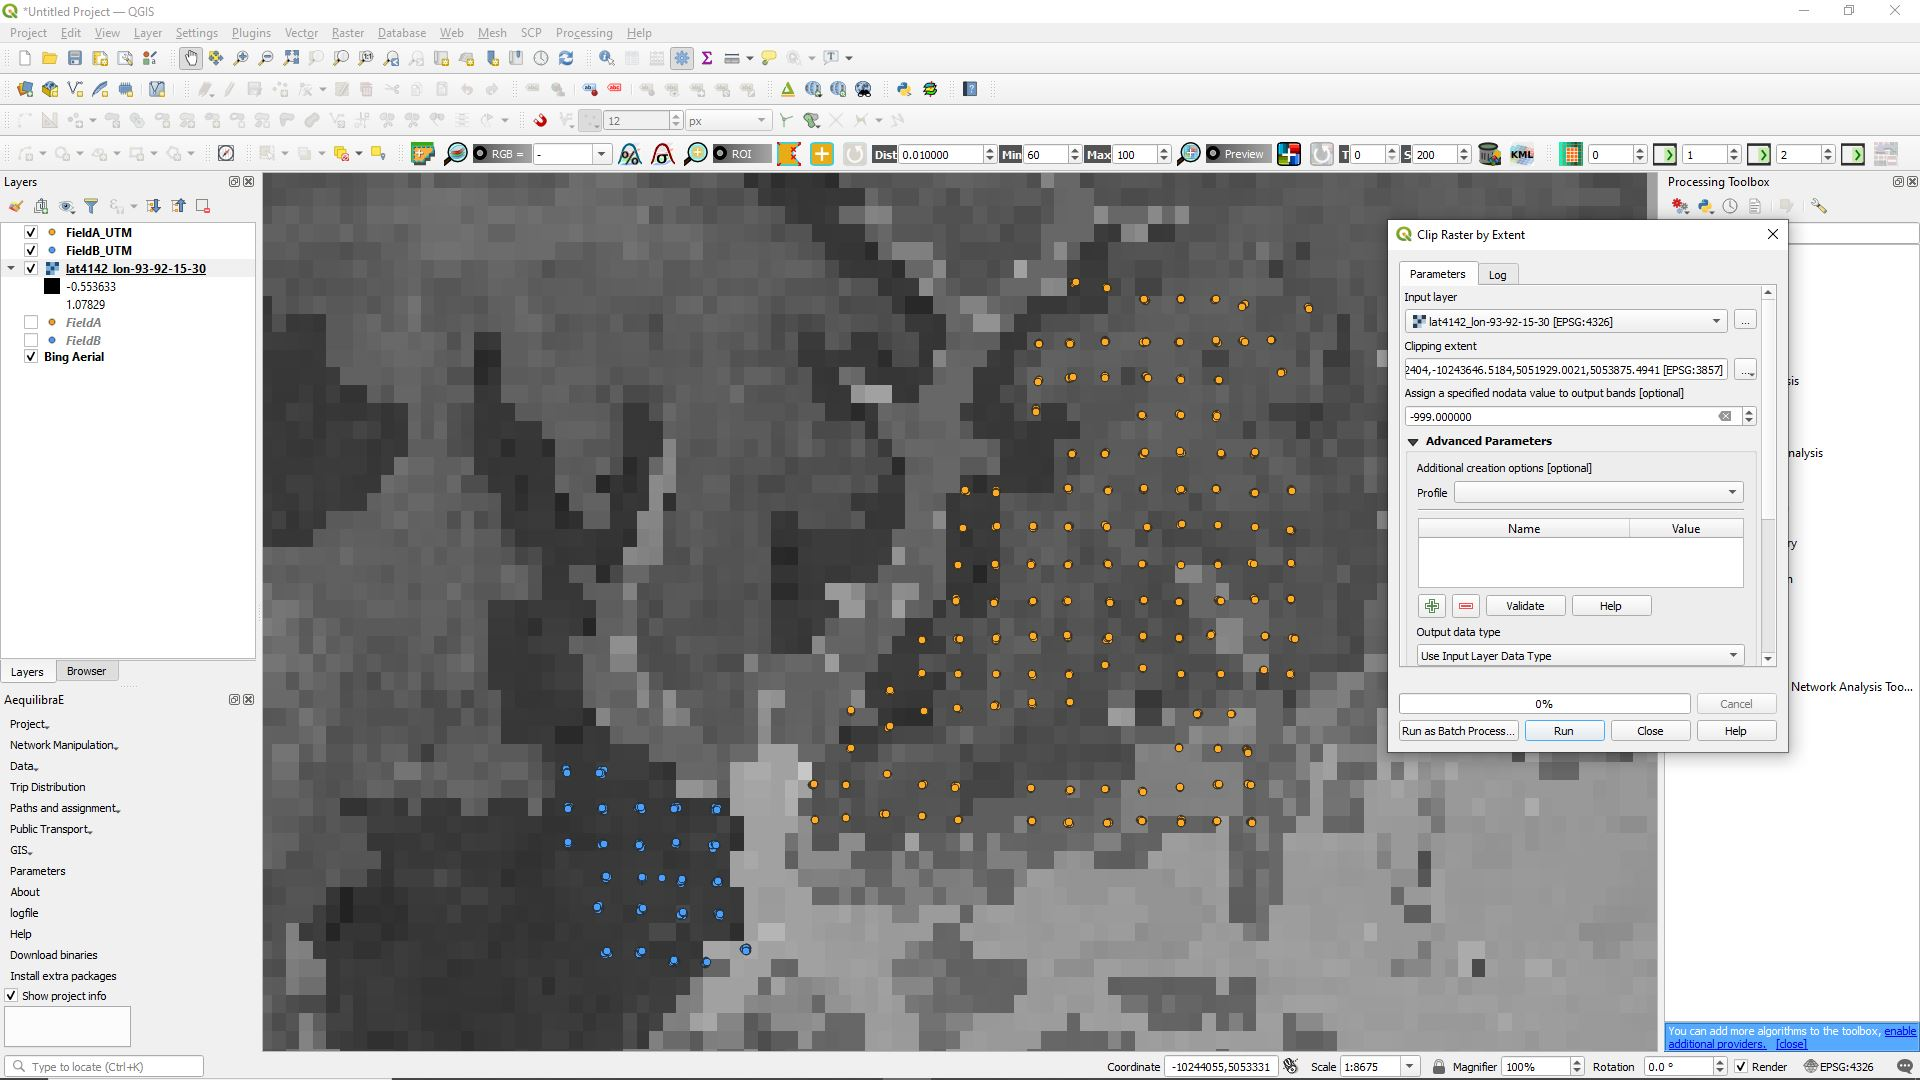

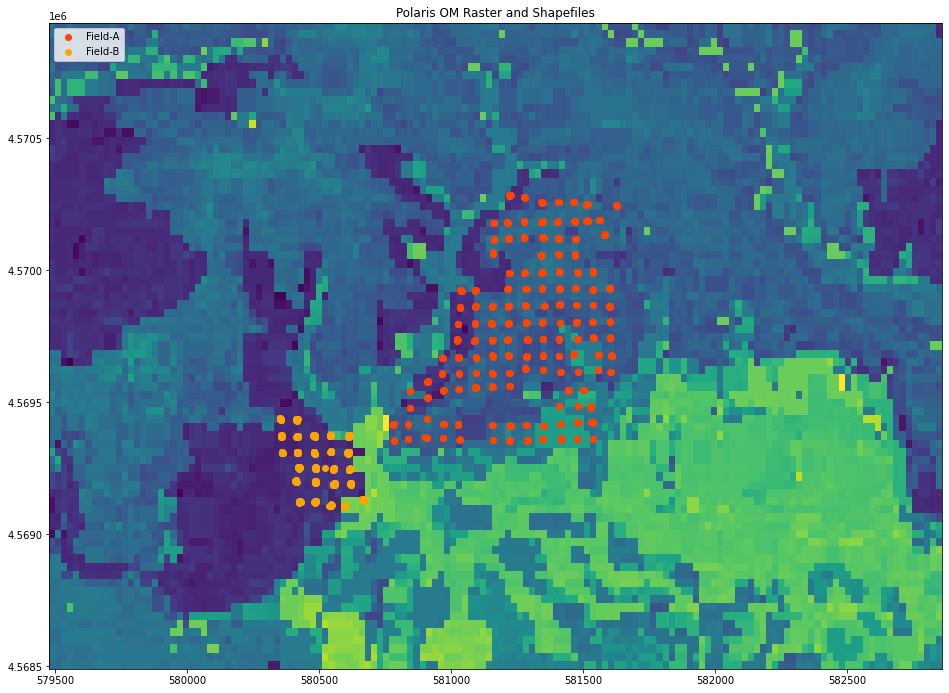

In [28]:
#Dispaly shapefiles and Polaris OM Raster
Region_A = gpd.read_file("Shapefiles_UTM/FieldA_UTM/FieldA_UTM.shp")
Region_B = gpd.read_file("Shapefiles_UTM/FieldB_UTM/FieldB_UTM.shp")
#Open the Polaris Organic Matter dataset
Polaris_om = rt.open('Polaris_om/Polaris_om_UTM.tif', masked = True)
affine = Polaris_om.transform
#Plot the datasets
fig, ax = plt.subplots(figsize = (16,12))
plt.title('Polaris OM Raster and Shapefiles')
Region_A.plot(ax=ax, color ='orangered', label="Field-A")
Region_B.plot(ax=ax, color = 'orange', label="Field-B")
show(Polaris_om, ax= ax)
plt.legend(loc="upper left")

In [29]:
#Retrieve SOM values from Polaris Dataset at the refrence points (Shapefiles)
def extract_SOM(raster, shapefile):
    SOM_max = rs.zonal_stats(shapefile, #Refrence points to retrieve SOM at
                             raster.values, #Polaris SOM raster
                             nodata=-999,
                             affine=affine,
                             geojson_out = True,
                             copy_properties=True,
                             stats="max") 
    return SOM_max

In [30]:
# Create Geopandas Dataframe
def create_GeoDataFrame(SOM_max):
    SOM_gdf = gpd.GeoDataFrame.from_features(SOM_max)
    return SOM_gdf
# Create Pandas Dataframe
def create_DataFrame(SOM_gdf):
    SOM_df = pd.DataFrame(SOM_gdf.drop(columns=['geometry'])) # Remove column not of interest
    return SOM_df

In [31]:
#Refrence Organic Matter - Polaris Dataset
SOM_Polaris = rtx.open_rasterio('Polaris_om/Polaris_om_UTM.tif', masked= True).squeeze()

In [32]:
#Extract the SOM values from Polaris Dataset at the refrence points
FieldA_ref = extract_SOM(SOM_Polaris, "Shapefiles_UTM/FieldA_UTM/FieldA_UTM.shp")
FieldB_ref = extract_SOM(SOM_Polaris, "Shapefiles_UTM/FieldB_UTM/FieldB_UTM.shp")

In [33]:
#Create geodataframe
#Convert Geodataframe into a dataframe
#Rename columns
gdf1 = create_GeoDataFrame(FieldA_ref)
df1 = create_DataFrame(gdf1)
df1.rename(columns={'som': 'Stenon_SOM', 'max':'Polaris_SOM'}, inplace= True)
gdf2 = create_GeoDataFrame(FieldB_ref)
df2 = create_DataFrame(gdf2)
df2.rename(columns={'som': 'Stenon_SOM', 'max':'Polaris_SOM'}, inplace= True)

In [34]:
#Poalris SOM dataset is in log10(%), to reverse the log10(%)
df1['Polaris_SOM'] = np.power(10, (df1['Polaris_SOM']))
df2['Polaris_SOM'] = np.power(10, (df2['Polaris_SOM']))

In [63]:
#df2

# Comparison 
### FieldA - Stenon SOM vs Polaris SOM

<AxesSubplot:xlabel='lng', ylabel='lat'>

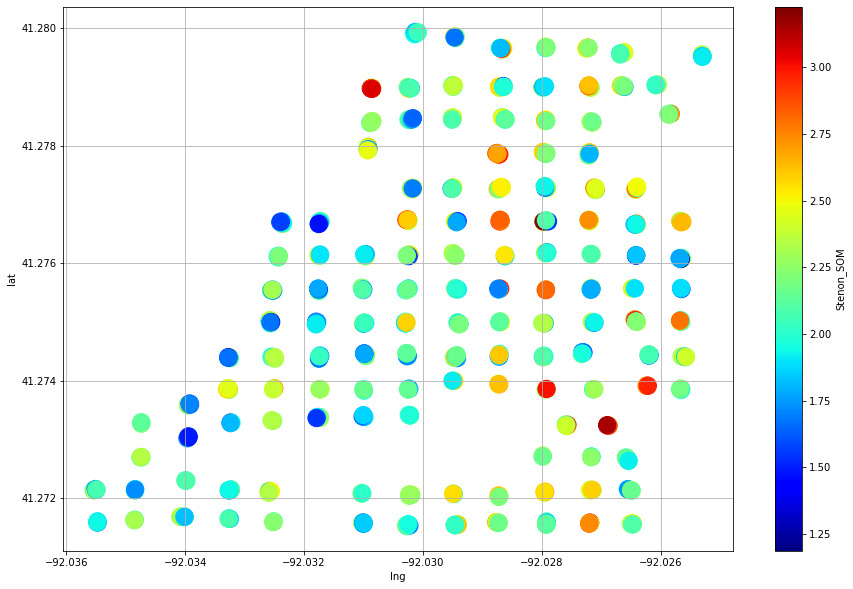

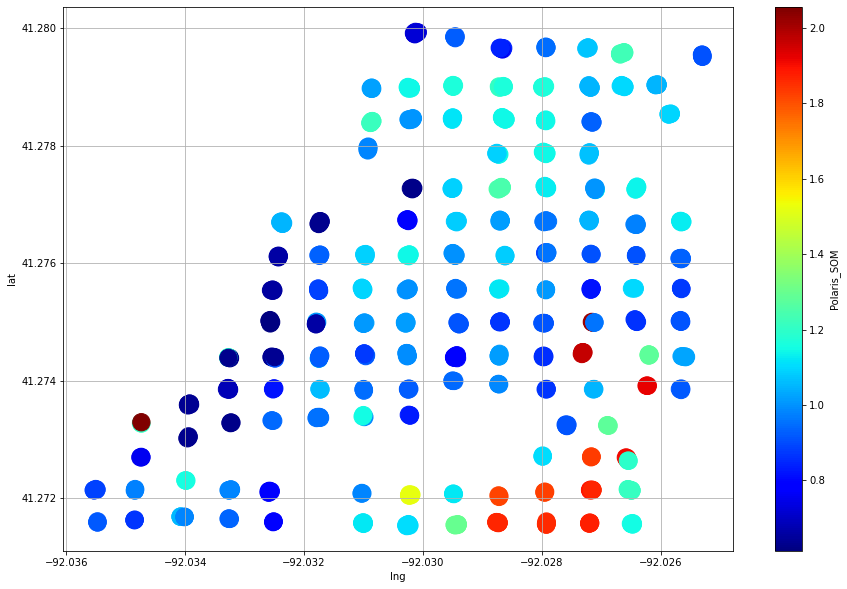

In [36]:
#PLot data for a comparison
df_A = pd.DataFrame(df1, columns=["Stenon_SOM", "Polaris_SOM"])
df_A_Sca = pd.DataFrame(df1, columns=["lat", "lng", "Stenon_SOM", "Polaris_SOM"])
plt.rcParams["figure.figsize"] = (15,10)
cmap = plt.cm.get_cmap('jet')
df_A_Sca.plot.scatter(y=0, x=1, c="Stenon_SOM", s=300, colormap=cmap, grid="both", sharex=False) #, ylim=[41.27664, 41.27676], yticks=np.arange(41.276, 41.278, 0.00001))
df_A_Sca.plot.scatter(y=0, x=1, c="Polaris_SOM", s=300, colormap=cmap, grid="both", sharex=False) #, ylim=[41.27664, 41.27676], yticks=np.arange(41.276, 41.278, 0.00001))

<AxesSubplot:title={'center':'FieldA - Stenon SOM vs Polaris SOM'}, ylabel='Density'>

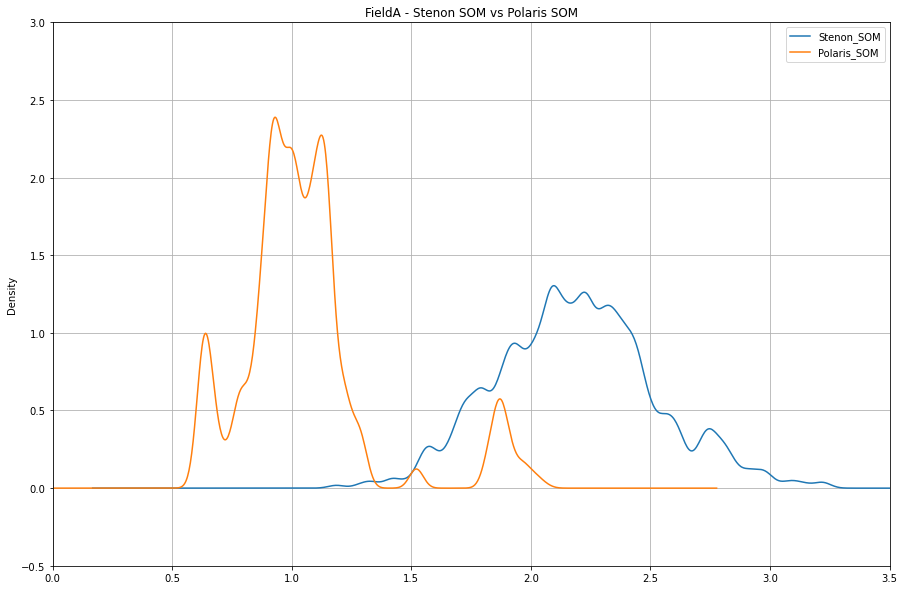

In [37]:
df_A.plot.kde(stacked=False, title = 'FieldA - Stenon SOM vs Polaris SOM', grid=True, xlim=[0.0, 3.5], ylim=[-0.5, 3], bw_method=0.1)

# Comparison 
### FieldB - Stenon SOM vs Polaris SOM

<AxesSubplot:xlabel='lng', ylabel='lat'>

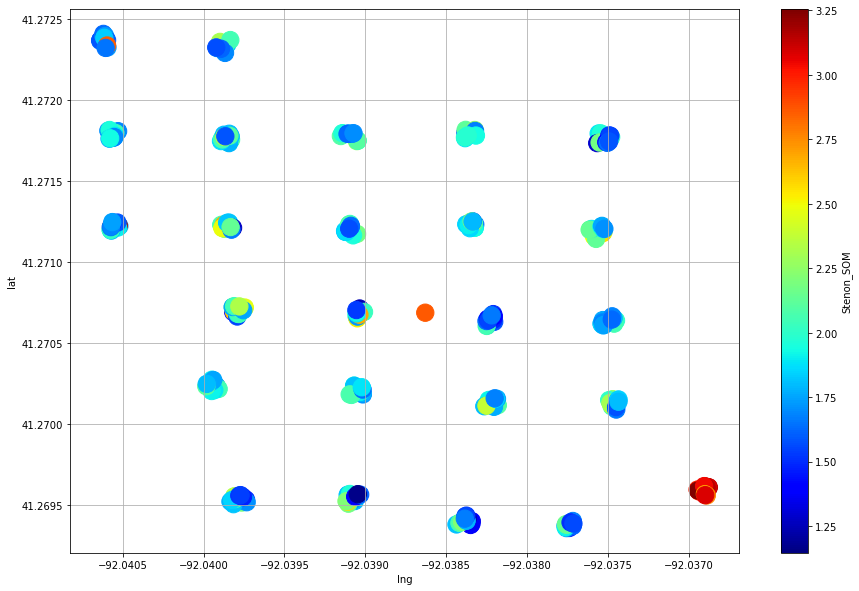

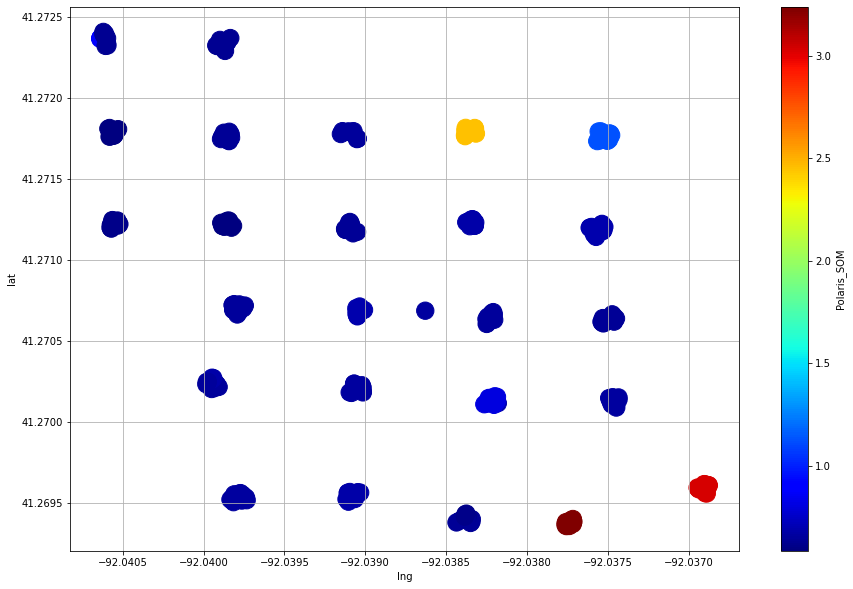

In [38]:
df_B = pd.DataFrame(df2, columns=["Stenon_SOM", "Polaris_SOM"])
df_B_Sca = pd.DataFrame(df2, columns=["lat", "lng", "Stenon_SOM", "Polaris_SOM"])
plt.rcParams["figure.figsize"] = (15,10)
cmap = plt.cm.get_cmap('jet')
df_B_Sca.plot.scatter(y=0, x=1, c="Stenon_SOM", s=300, colormap=cmap, grid="both", sharex=False) 
df_B_Sca.plot.scatter(y=0, x=1, c="Polaris_SOM", s=300, colormap=cmap, grid="both", sharex=False) 

<AxesSubplot:title={'center':'FieldB - Stenon SOM vs Polaris SOM'}, ylabel='Density'>

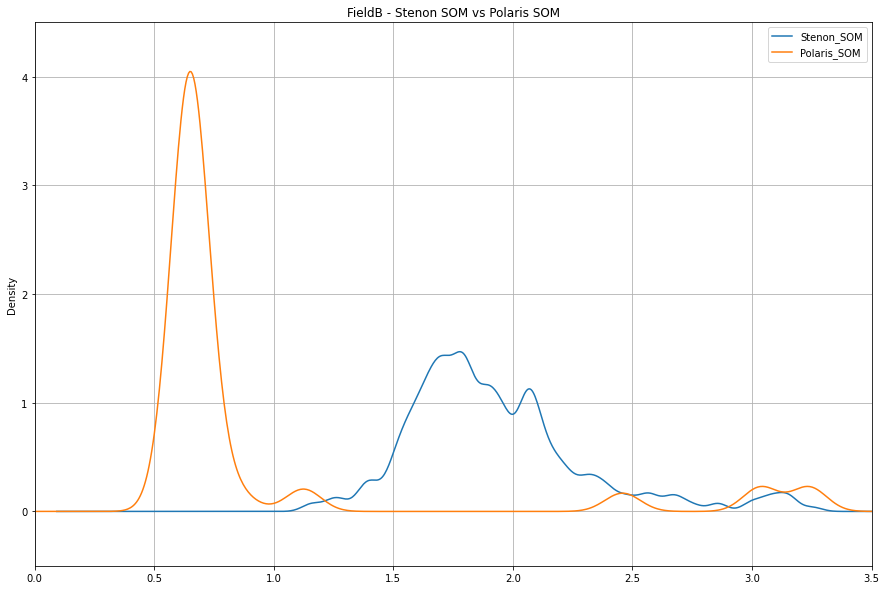

In [39]:
df_B.plot.kde(stacked=False, title = 'FieldB - Stenon SOM vs Polaris SOM', grid=True, xlim=[0.0, 3.5], ylim=[-0.5, 4.5], bw_method=0.1)

## Task 3

### Create Machine Learning Models
### Applied few ML models on raster data to build continuous raster's, with a preference for Linear Regression or Random Forest.

### Model 1 : Multiple Linear regression model

In [50]:
#Multiple Linear regression model
#load the data
ds_A = pd.read_csv('Task3_CSVs/FieldA_Pro.csv')
#Load the independent variables
X = ds_A.iloc[:, 1:].values
#Load the dependent variables
y = ds_A.iloc[:, 0].values

In [57]:
#Multiple Linear Regression model training
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
#Preperation of training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

from sklearn.linear_model import LinearRegression
mlr_regressor = LinearRegression()
mlr_regressor.fit(X_train, y_train)
y_pred = mlr_regressor.predict(X_test)

#Write results to seperate dataframe and display
mlr_results = {'Intercept': [mlr_regressor.intercept_],
               'Coefficients': [mlr_regressor.coef_],
               'r-squared score': [mlr_regressor.score(X_train, y_train)]}
mlr_df = pd.DataFrame(mlr_results, columns = ['Intercept', 'Coefficients', 'r-squared score'])

In [58]:
mlr_df

,Intercept,Coefficients,r-squared score
0,2.172916,"[157.67134361282316, -725.7072519953417, 880.1...",0.802783


 ### Model 2 : Random Forest
 ### Curious - often used in remote sensing to generate continuous rasters

In [59]:
#Independent Variables
signatures = ds_A.iloc[:, 1:].values
#Dependent Variables
SOM_obs = ds_A.iloc[:, 0].values

from sklearn.model_selection import train_test_split
train_signatures, test_signatures, train_SOM_obs, test_SOM_obs = train_test_split(signatures, SOM_obs, test_size = 0.3, random_state = 0)

from sklearn.ensemble import RandomForestRegressor
RFReg = RandomForestRegressor(n_estimators=100, max_depth =3, n_jobs= -1, random_state = 0)
RFReg.fit(train_signatures, train_SOM_obs) #Fit the training dataset to the model

RandomForestRegressor(max_depth=3, n_jobs=-1, random_state=0)

In [60]:
#Predict SOM values based on the created model with parameters pre-defined
SOM_obs_pred_rf = RFReg.predict((test_signatures))
from sklearn import metrics
r_square_rf = metrics.r2_score(test_SOM_obs, SOM_obs_pred_rf)
print('r-squared', r_square_rf)

r-squared 0.05792991527879554


# Inference
## MLR

In [61]:
#MLR - Inference on Field B dataset
inference = pd.read_csv('Task3_CSVs/FieldB_Pro.csv')
SOM_pred_MLR = mlr_regressor.predict(inference)
print(SOM_pred_MLR)

[2.05832297e+08 1.88923082e+08 3.12912174e+08 2.30251020e+08
 2.01295809e+08 3.29262068e+08 2.64649933e+08 2.59560990e+08
 3.04160331e+08 3.38130899e+08 2.98092529e+08 3.03549381e+08
 2.68675959e+08 2.90578271e+08 2.47536569e+08 2.85356775e+08
 3.03844657e+08 1.25457973e+08 1.53659502e+08 2.33752610e+08
 2.43726158e+08 6.43704750e+07 2.07726121e+08 1.64823251e+08
 1.90317450e+08 2.30863428e+08 1.74797307e+08 1.51352434e+08
 1.97257800e+08 1.04176277e+08 1.77705975e+08 1.71453538e+08
 1.82887041e+08 1.54517453e+08 2.01834441e+08 1.91790261e+08
 1.16591119e+08 1.55763415e+08 1.34949814e+08 1.59389842e+08
 1.31063993e+08 1.56590085e+08 2.00235890e+08 1.22021515e+08
 1.55166927e+08 1.94316647e+08 1.26715539e+08 1.20573674e+08
 2.14571687e+08 1.58144002e+08 2.41059942e+08 1.90980572e+08
 1.85813840e+08 1.14053312e+08 1.61769103e+08 1.50471257e+08
 2.08337259e+08 2.03199342e+08 1.84412459e+08 1.81770981e+08
 2.67517722e+08 2.02776304e+08 1.73665212e+08 1.38862743e+08
 2.62696942e+08 1.432325

## Random Forest

In [62]:
#Random Forest - infernce on Field B dataset
SOM_pred_RF = RFReg.predict(inference)
print(SOM_pred_RF)

[2.25578811 2.25638537 2.17080667 2.15320926 2.0824809  2.14781979
 2.16435598 2.28682972 2.25752259 2.30757558 2.24055866 2.21695786
 2.20105985 2.27004214 2.26612024 2.25561609 2.24421805 2.22855013
 2.21965986 2.18816716 2.17090865 2.15569807 2.24289667 2.26502525
 2.29581736 2.26844996 2.14232147 2.33175532 2.29653577 2.15563724
 2.24097631 2.18804036 2.22783931 2.27383811 2.24156875 2.12909467
 2.27187056 2.24313986 2.24656865 2.2448626  2.284598   2.22596751
 2.19573704 2.17601952 2.18681075 2.24814675 2.12659006 2.08518594
 2.2477258  2.28956905 2.27062179 2.24601974 2.2676492  2.26991472
 2.27588413 2.17448751 2.22904716 2.15396529 2.14478438 2.3100488
 2.17552833 2.26538838 2.28573029 2.2426234  2.22834439 2.22373173
 2.23124717 2.2376107  2.26133245 2.16751924 2.1733717  2.13109113
 2.10599568 2.34509154 2.1792168  2.24522446 2.29583804 2.2448626
 2.17064007 2.25805186 2.25392438 2.24857209 2.27999525 2.27939237
 2.29655099 2.26217496 2.26338175 2.24492171 2.2716412  2.271315